In [21]:
# %% Imports

import numpy as np
import pandas as pd
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.metrics import (
    balanced_accuracy_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

from sklearn.feature_selection import f_classif

from helpers import *  # if you still need it

sns.set(style="whitegrid")

import scanpy as sc
import muon as mu
import mofax as mofa


### Load data

In [2]:
# %% Load data

data_dir = "./../data/TCGA-BRCA/"
views = ["mRNA", "DNAm", "RPPA"]

data = {}
for omic in views:
    with open(f"{data_dir}{omic}.pkl", "rb") as f:
        data[omic] = pickle.load(f)

list(data.keys())


['mRNA', 'DNAm', 'RPPA']

In [3]:
# %% Build intersection and union patient sets

idx_rna  = set(data["mRNA"]["expr"].index)
idx_meth = set(data["DNAm"]["expr"].index)
idx_prot = set(data["RPPA"]["expr"].index)

patients_intersection = sorted(idx_rna & idx_meth & idx_prot)
patients_union        = sorted(idx_rna | idx_meth | idx_prot)

print(f"mRNA samples: {len(idx_rna)}")
print(f"DNAm samples: {len(idx_meth)}")
print(f"RPPA samples: {len(idx_prot)}")
print(f"Intersection (all three): {len(patients_intersection)}")
print(f"Union (at least one): {len(patients_union)}")


mRNA samples: 500
DNAm samples: 500
RPPA samples: 500
Intersection (all three): 401
Union (at least one): 658


In [4]:
# %% PAM50 helpers

def get_pam50_raw(view_name: str) -> pd.Series:
    meta = data[view_name].get("meta", None)
    if meta is None or "paper_BRCA_Subtype_PAM50" not in meta.columns:
        return pd.Series(index=[], dtype="object")
    s = meta["paper_BRCA_Subtype_PAM50"].astype(str).str.strip()
    s = s.replace({"nan": np.nan, "None": np.nan, "": np.nan})
    s.name = view_name
    return s

pam_rna_full  = get_pam50_raw("mRNA")
pam_meth_full = get_pam50_raw("DNAm")
pam_prot_full = get_pam50_raw("RPPA")

# "Any modality" PAM50 label
pam_any = pam_rna_full.copy()
pam_any = pam_any.combine_first(pam_meth_full)
pam_any = pam_any.combine_first(pam_prot_full)
pam_any.name = "PAM50_any"

print("PAM50_any non-null:", pam_any.notna().sum())


PAM50_any non-null: 658


In [5]:
# %% PAM50 for intersection patients

pam_rna_int  = pam_rna_full.reindex(patients_intersection)
pam_meth_int = pam_meth_full.reindex(patients_intersection)
pam_prot_int = pam_prot_full.reindex(patients_intersection)

pam_df_int = pd.concat([pam_rna_int, pam_meth_int, pam_prot_int], axis=1)
pam_df_int.columns = ["mRNA", "DNAm", "RPPA"]

# prefer mRNA, then DNAm, then RPPA within intersection
pam50_intersection = pam_df_int.bfill(axis=1).iloc[:, 0].dropna()
patients_int_labeled = pam50_intersection.index.tolist()

print("Intersection patients with PAM50:", len(patients_int_labeled))
pam_df_int.head()


Intersection patients with PAM50: 401


,mRNA,DNAm,RPPA
TCGA-3C-AALI,Her2,Her2,Her2
TCGA-4H-AAAK,LumA,LumA,LumA
TCGA-5L-AAT1,LumA,LumA,LumA
TCGA-A1-A0SF,LumA,LumA,LumA
TCGA-A1-A0SH,LumA,LumA,LumA


### Helper functions

In [ ]:
def build_mdata_and_run_mofa(
    dna_expr: pd.DataFrame,
    rna_expr: pd.DataFrame,
    rppa_expr: pd.DataFrame,
    meta_source: dict,
    outfile: str,
    n_factors: int = 15,
) -> mu.MuData:
    """
    Build a MuData object from 3 omics matrices and run MOFA.
    Returns the fitted MuData object (with .obsm['X_mofa']).
    """
    # Keep consistent sample order
    all_samples = dna_expr.index.union(rna_expr.index).union(rppa_expr.index)

    dna  = dna_expr.reindex(all_samples)
    rna  = rna_expr.reindex(all_samples)
    rppa = rppa_expr.reindex(all_samples)

    print("Expression shapes used for MOFA:")
    print("  DNAm:", dna.shape)
    print("  mRNA:", rna.shape)
    print("  RPPA:", rppa.shape)

    mods = {
        "dna":  sc.AnnData(dna),
        "rna":  sc.AnnData(rna),
        "rppa": sc.AnnData(rppa),
    }

    mdata = mu.MuData(mods)

    # Attach combined metadata (optional but nice)
    meta_dna  = meta_source["DNAm"]["meta"].reindex(all_samples)
    meta_rna  = meta_source["mRNA"]["meta"].reindex(all_samples)
    meta_rppa = meta_source["RPPA"]["meta"].reindex(all_samples)

    meta = pd.concat([meta_dna, meta_rna, meta_rppa], axis=1)
    meta = meta.loc[:, ~meta.columns.duplicated()]
    mdata.obs = meta

    print("\nRunning MOFA...")
    mu.tl.mofa(
        mdata,
        use_obs="union",  # use all samples present in MuData
        n_factors=n_factors,
        convergence_mode="medium",
        outfile=outfile,
    )
    print("MOFA finished. Factors stored in mdata.obsm['X_mofa']")

    return mdata

def classify_from_mofa(
    mdata: mu.MuData,
    label_series: pd.Series,
    title: str = "MOFA classification",
):
    """
    Align labels to MOFA samples, run logistic regression with CV,
    and print / plot metrics.
    """
    X_mofa = mdata.obsm["X_mofa"]
    mofa_scores = pd.DataFrame(
        X_mofa,
        index=mdata.obs.index,
        columns=[f"Factor{i+1}" for i in range(X_mofa.shape[1])]
    )

    # Align labels to MOFA samples
    pam_mofa = label_series.reindex(mofa_scores.index).dropna()
    X = mofa_scores.loc[pam_mofa.index].values
    y_str = pam_mofa.values

    le = LabelEncoder()
    y = le.fit_transform(y_str)

    Xtr, Xte, ytr, yte = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    clf = LogisticRegression(
        solver="saga",
        multi_class="multinomial",
        max_iter=5000,
        class_weight="balanced",
        n_jobs=-1,
        random_state=42,
    )

    mofa_pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", clf),
    ])

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    param_grid = {
        "clf__C": [0.01, 0.1, 1, 10, 100],
        "clf__penalty": ["l1", "l2"],
    }

    print(f"\n=== Logistic regression on MOFA factors: {title} ===")
    gs = GridSearchCV(
        mofa_pipeline,
        param_grid,
        scoring="balanced_accuracy",
        cv=cv,
        n_jobs=-1,
        verbose=2,
        refit=True,
    )
    gs.fit(Xtr, ytr)

    print("Best params:", gs.best_params_)
    y_pred = gs.predict(Xte)
    proba  = gs.predict_proba(Xte)

    print("Balanced Acc:",
          balanced_accuracy_score(yte, y_pred).round(3))
    print("ROC-AUC (OvR, weighted):",
          roc_auc_score(yte, proba, multi_class="ovr", average="weighted").round(3))
    print(classification_report(yte, y_pred, digits=3))
    print("Confusion matrix:\n", confusion_matrix(yte, y_pred))

    classes = le.classes_
    cm = confusion_matrix(yte, y_pred)

    fig, ax = plt.subplots()
    disp = ConfusionMatrixDisplay(cm, display_labels=classes)
    disp.plot(ax=ax, cmap="viridis", colorbar=True)
    ax.grid(False)
    plt.title(title)
    plt.show()

def select_top_anova_features(data: dict,
                              y: pd.Series,
                              n_keep: dict,
                              views: list[str] | None = None):
    """
    Select top ANOVA-ranked features per view using f_classif.

    Parameters
    ----------
    data : dict
        data[view]["expr"] must be DataFrame (samples x features).
    y : pd.Series or array-like
        Class labels for ANOVA.
    n_keep : dict
        Dictionary specifying number of features to keep per view.
        Example: {"mrna": 2000, "meth": 8000, "prot": 50}
    views : list of str or None
        Which views to process. If None, use all keys in `data`.

    Returns
    -------
    filtered_data : dict
        Same structure as `data`, but with expr reduced to top ANOVA features.
    feature_indices : dict
        For each view, Index of selected feature names.
    """

    if views is None:
        views = list(data.keys())

    filtered_data = {}
    feature_indices = {}

    for v in views:
        X = data[v]["expr"]  # samples x features
        X_values = X.values

        # Compute ANOVA F-values
        F, pvals = f_classif(X_values, y)

        # convert to pandas series for easy sorting
        F = pd.Series(F, index=X.columns)

        # drop NaN (happens if a feature is constant)
        F = F.dropna()

        k = min(n_keep.get(v, X.shape[1]), F.shape[0])
        top_feats = F.sort_values(ascending=False).head(k).index

        feature_indices[v] = top_feats

        new_view = dict(data[v])
        new_view["expr"] = data[v]["expr"][top_feats]
        filtered_data[v] = new_view

        print(f"{v}: kept {k} / {X.shape[1]} features (ANOVA)")

    return filtered_data, feature_indices

# %% Helper: ANOVA feature selection for UNION (per view)

def select_top_anova_features_union(data_dict, pam_union_nonnull, n_keep_union):
    """
    Run ANOVA separately per view, using all patients that:
    - have PAM50 label, AND
    - have non-missing expression in that view.

    Returns:
        selected_feats_union: dict of selected feature names per view.
    """

    selected_feats_union = {}

    for v in ["mRNA", "DNAm", "RPPA"]:
        expr = data_dict[v]["expr"]  # full expr matrix for that view

        # patients with both expression + PAM50
        patients_v = expr.index.intersection(pam_union_nonnull.index)

        X_v = expr.loc[patients_v]
        y_v_str = pam_union_nonnull.loc[patients_v].astype(str).values

        le = LabelEncoder()
        y_v = le.fit_transform(y_v_str)

        print(f"\n{v}: patients used for ANOVA = {len(patients_v)}")

        F, pvals = f_classif(X_v.values, y_v)
        F = pd.Series(F, index=X_v.columns).dropna()

        k = min(n_keep_union.get(v, X_v.shape[1]), F.shape[0])
        top_feats = F.sort_values(ascending=False).head(k).index
        selected_feats_union[v] = top_feats

        print(f"{v}: kept {k} / {X_v.shape[1]} features (ANOVA union)")

    return selected_feats_union


### Intersecting patients

In [9]:
# Intersection-based ANOVA + MOFA

# We only use patients with PAM50 labels in the intersection
X_mrna_int = data["mRNA"]["expr"].loc[patients_int_labeled]
X_meth_int = data["DNAm"]["expr"].loc[patients_int_labeled]
X_prot_int = data["RPPA"]["expr"].loc[patients_int_labeled]

y_int_str = pam50_intersection.loc[patients_int_labeled].astype(str).values
y_int_le  = LabelEncoder().fit_transform(y_int_str)

print("Intersection ANOVA samples:", len(y_int_le))

# Build a data dict restricted to these patients for ANOVA
data_int_for_anova = {
    "mRNA": {"expr": X_mrna_int},
    "DNAm": {"expr": X_meth_int},
    "RPPA": {"expr": X_prot_int},
}

# How many features to keep (you can change RPPA to 25 if you want)
n_keep_int = {
    "mRNA": 2623,
    "DNAm": 8699,
    "RPPA": 464,
}

filtered_int, selected_feats_int = select_top_anova_features(
    data=data_int_for_anova,
    y=y_int_le,
    n_keep=n_keep_int,
    views=["mRNA", "DNAm", "RPPA"],
)


Intersection ANOVA samples: 401
mRNA: kept 2623 / 29995 features (ANOVA)
DNAm: kept 8699 / 100000 features (ANOVA)
RPPA: kept 464 / 464 features (ANOVA)


In [12]:
# Build MOFA for intersection patients

dna_int  = filtered_int["DNAm"]["expr"]
rna_int  = filtered_int["mRNA"]["expr"]
rppa_int = filtered_int["RPPA"]["expr"]

mdata_int = build_mdata_and_run_mofa(
    dna_expr=dna_int,
    rna_expr=rna_int,
    rppa_expr=rppa_int,
    meta_source=data,
    outfile="exports/MOFA_ANOVA_intersection.hdf5",
    n_factors=15,
)


Expression shapes used for MOFA:
  DNAm: (401, 8699)
  mRNA: (401, 2623)
  RPPA: (401, 464)

Running MOFA...

        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        
Loaded view='dna' group='group1' with N=401 samples and D=8699 features...
Loaded view='rna' group='group1' with N=401 samples and D=2623 features...
Loaded view='rppa' group='group1' with N=401 samples and D=464 features...


Model options:
- Automatic Relevance Determin

/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/mudata/_core/mudata.py:1598: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/mudata/_core/mudata.py:1461: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("obs", axis=1, join_common=join_common)




######################################
## Training the model with seed 1 ##
######################################



Converged!



#######################
## Training finished ##
#######################


Saving model in exports/MOFA_ANOVA_intersection.hdf5...
Saved MOFA embeddings in .obsm['X_mofa'] slot and their loadings in .varm['LFs'].
MOFA finished. Factors stored in mdata.obsm['X_mofa']



=== Logistic regression on MOFA factors: Intersection patients ===
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END .......................clf__C=0.01, clf__penalty=l1; total time=   0.0s
[CV] END .......................clf__C=0.01, clf__penalty=l1; total time=   0.0s
[CV] END .......................clf__C=0.01, clf__penalty=l1; total time=   0.0s
[CV] END .......................clf__C=0.01, clf__penalty=l1; total time=   0.0s
[CV] END .......................clf__C=0.01, clf__penalty=l1; total time=   0.0s
[CV] END .......................clf__C=0.01, clf__penalty=l2; total time=   0.0s
[CV] END .......................clf__C=0.01, clf__penalty=l2; total time=   0.0s
[CV] END .......................clf__C=0.01, clf__penalty=l2; total time=   0.0s
[CV] END .......................clf__C=0.01, clf__penalty=l2; total time=   0.0s
[CV] END .......................clf__C=0.01, clf__penalty=l2; total time=   0.0s
[CV] END ........................clf__C=0.1, clf__penalty=l1;

/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: F

[CV] END .........................clf__C=10, clf__penalty=l2; total time=   0.1s
[CV] END .........................clf__C=10, clf__penalty=l1; total time=   0.2s
[CV] END .........................clf__C=10, clf__penalty=l1; total time=   0.2s
[CV] END ........................clf__C=100, clf__penalty=l2; total time=   0.1s
[CV] END ........................clf__C=100, clf__penalty=l1; total time=   0.1s
[CV] END ........................clf__C=100, clf__penalty=l1; total time=   0.3s
[CV] END .........................clf__C=10, clf__penalty=l1; total time=   0.1s
[CV] END ........................clf__C=100, clf__penalty=l2; total time=   0.2s
[CV] END ........................clf__C=100, clf__penalty=l2; total time=   0.1s
[CV] END ........................clf__C=100, clf__penalty=l2; total time=   0.1s
[CV] END ........................clf__C=100, clf__penalty=l1; total time=   0.3s
[CV] END .........................clf__C=10, clf__penalty=l1; total time=   0.1s
[CV] END ...................

/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: F

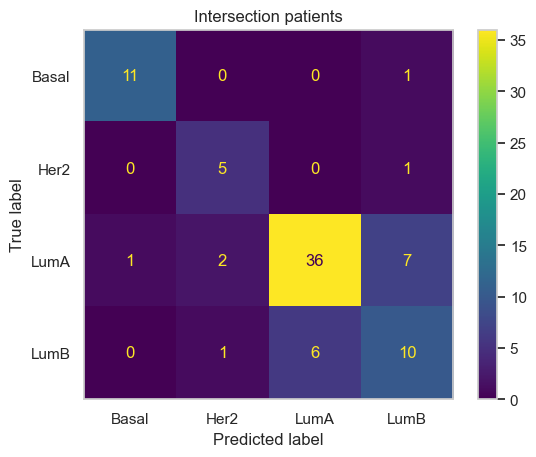

In [27]:
# Classification on intersection MOFA factors

classify_from_mofa(
    mdata=mdata_int,
    label_series=pam_any,
    title="Intersection patients",
)

### Union patients

In [24]:
# Union-based ANOVA + MOFA

# PAM50 labels for union
pam_union = pam_any.reindex(patients_union)
pam_union_nonnull = pam_union.dropna()
patients_union_labeled = pam_union_nonnull.index.tolist()

print("Union patients with PAM50:", len(patients_union_labeled))

# Run ANOVA for union (per view)

data_union_full = {
    "mRNA": {"expr": data["mRNA"]["expr"]},
    "DNAm": {"expr": data["DNAm"]["expr"]},
    "RPPA": {"expr": data["RPPA"]["expr"]},
}

n_keep_union = {
    "mRNA": 2623,
    "DNAm": 8699,
    "RPPA": 464,
}

selected_feats_union = select_top_anova_features_union(
    data_dict=data_union_full,
    pam_union_nonnull=pam_union_nonnull,
    n_keep_union=n_keep_union,
)


Union patients with PAM50: 658

mRNA: patients used for ANOVA = 500
mRNA: kept 2623 / 29995 features (ANOVA union)

DNAm: patients used for ANOVA = 500
DNAm: kept 8699 / 100000 features (ANOVA union)

RPPA: patients used for ANOVA = 500
RPPA: kept 464 / 464 features (ANOVA union)


In [25]:
# Build union matrices for MOFA (all union patients, missing allowed)

dna_union  = data["DNAm"]["expr"][selected_feats_union["DNAm"]].reindex(patients_union)
rna_union  = data["mRNA"]["expr"][selected_feats_union["mRNA"]].reindex(patients_union)
rppa_union = data["RPPA"]["expr"][selected_feats_union["RPPA"]].reindex(patients_union)

print("DNAm union shape:", dna_union.shape)
print("mRNA union shape:", rna_union.shape)
print("RPPA union shape:", rppa_union.shape)


DNAm union shape: (658, 8699)
mRNA union shape: (658, 2623)
RPPA union shape: (658, 464)


Expression shapes used for MOFA:
  DNAm: (658, 8699)
  mRNA: (658, 2623)
  RPPA: (658, 464)

Running MOFA...

        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        
Loaded view='dna' group='group1' with N=658 samples and D=8699 features...
Loaded view='rna' group='group1' with N=658 samples and D=2623 features...
Loaded view='rppa' group='group1' with N=658 samples and D=464 features...


Model options:
- Automatic Relevance Determin

/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: F

[CV] END .......................clf__C=0.01, clf__penalty=l1; total time=   0.0s
[CV] END .......................clf__C=0.01, clf__penalty=l1; total time=   0.0s
[CV] END ........................clf__C=0.1, clf__penalty=l1; total time=   0.1s
[CV] END .......................clf__C=0.01, clf__penalty=l1; total time=   0.0s
[CV] END .......................clf__C=0.01, clf__penalty=l2; total time=   0.0s
[CV] END ........................clf__C=0.1, clf__penalty=l1; total time=   0.0s
[CV] END .......................clf__C=0.01, clf__penalty=l1; total time=   0.0s
[CV] END ........................clf__C=0.1, clf__penalty=l1; total time=   0.0s
[CV] END .......................clf__C=0.01, clf__penalty=l1; total time=   0.0s
[CV] END ........................clf__C=0.1, clf__penalty=l2; total time=   0.0s
[CV] END ........................clf__C=0.1, clf__penalty=l1; total time=   0.0s
[CV] END ........................clf__C=0.1, clf__penalty=l2; total time=   0.0s
[CV] END ...................

/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: F

[CV] END ........................clf__C=0.1, clf__penalty=l2; total time=   0.0s
[CV] END .......................clf__C=0.01, clf__penalty=l2; total time=   0.0s
[CV] END ........................clf__C=0.1, clf__penalty=l2; total time=   0.0s
[CV] END ........................clf__C=0.1, clf__penalty=l2; total time=   0.0s
[CV] END ..........................clf__C=1, clf__penalty=l1; total time=   0.1s
[CV] END .......................clf__C=0.01, clf__penalty=l2; total time=   0.0s
[CV] END ..........................clf__C=1, clf__penalty=l2; total time=   0.1s[CV] END ..........................clf__C=1, clf__penalty=l2; total time=   0.0s

[CV] END .......................clf__C=0.01, clf__penalty=l2; total time=   0.0s
[CV] END ..........................clf__C=1, clf__penalty=l2; total time=   0.0s
[CV] END ..........................clf__C=1, clf__penalty=l1; total time=   0.1s
[CV] END ..........................clf__C=1, clf__penalty=l1; total time=   0.1s
[CV] END ...................

/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: F

[CV] END .........................clf__C=10, clf__penalty=l2; total time=   0.1s
[CV] END .........................clf__C=10, clf__penalty=l2; total time=   0.1s
[CV] END .........................clf__C=10, clf__penalty=l2; total time=   0.1s
[CV] END .........................clf__C=10, clf__penalty=l1; total time=   0.2s
[CV] END .........................clf__C=10, clf__penalty=l2; total time=   0.1s
[CV] END .........................clf__C=10, clf__penalty=l1; total time=   0.2s
[CV] END .........................clf__C=10, clf__penalty=l1; total time=   0.3s
[CV] END .........................clf__C=10, clf__penalty=l1; total time=   0.3s
[CV] END ........................clf__C=100, clf__penalty=l1; total time=   0.3s
[CV] END ........................clf__C=100, clf__penalty=l2; total time=   0.2s


/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/miniconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END .........................clf__C=10, clf__penalty=l1; total time=   0.4s
[CV] END ........................clf__C=100, clf__penalty=l1; total time=   0.2s
[CV] END ........................clf__C=100, clf__penalty=l1; total time=   0.3s
[CV] END ........................clf__C=100, clf__penalty=l2; total time=   0.1s
[CV] END ........................clf__C=100, clf__penalty=l2; total time=   0.2s
[CV] END ........................clf__C=100, clf__penalty=l1; total time=   0.3s
[CV] END ........................clf__C=100, clf__penalty=l2; total time=   0.2s
[CV] END ........................clf__C=100, clf__penalty=l2; total time=   0.3s
[CV] END ........................clf__C=100, clf__penalty=l1; total time=   0.4s
Best params: {'clf__C': 0.1, 'clf__penalty': 'l1'}
Balanced Acc: 0.799
ROC-AUC (OvR, weighted): 0.9
              precision    recall  f1-score   support

           0      0.885     0.958     0.920        24
           1      0.889     0.800     0.842        10
        

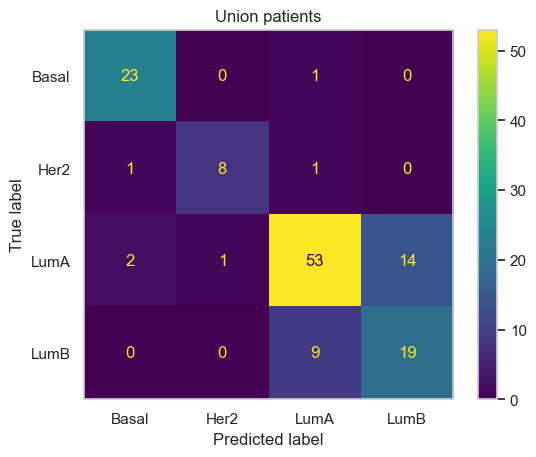

In [26]:
# Run MOFA for union patients

mdata_union = build_mdata_and_run_mofa(
    dna_expr=dna_union,
    rna_expr=rna_union,
    rppa_expr=rppa_union,
    meta_source=data,
    outfile="exports/MOFA_ANOVA_union.hdf5",
    n_factors=15,
)


# Classification on union MOFA factors

classify_from_mofa(
    mdata=mdata_union,
    label_series=pam_any,
    title="Union patients",
)